In [108]:
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = "cuda" if torch.cuda.is_available() else "cpu"

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


PyTorch Version: 2.5.1
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 4090 Laptop GPU


In [109]:
def hyperbolic_discounting_loss(preds, targets, confs, time_horizons = [1,3,5,10], beta=0.5):
    """
    Calculate loss with hyperbolic discounting and confidence weighting.
    Args:
        preds: Predicted prices (batch_size, 4)
        targets: True prices (batch_size, 4)
        confs: Predicted confidence values (batch_size, 4)
        beta: Hyperbolic discount factor
            - Higher beta means more discounting for longer time horizons i.e. more impulsive
            - Lower beta means less discounting, more patience
        time_horizons: List of time horizons in trading days

    """
    time_horizons = torch.tensor(time_horizons, device=preds.device)  # Trading days
    discount_weights = 1 / (1 + beta * time_horizons)
    mse_loss = (preds - targets).pow(2)
    weighted_loss = discount_weights * mse_loss / (confs + 1e-6)  # Confidence adjustment
    confidence_penalty = torch.log(confs + 1e-6).mean()  # Encourage confident predictions
    return weighted_loss.mean() + 0.01 * confidence_penalty  # Regularize confidence


In [110]:
# Step 1: Create Target Columns
def create_targets(df, target_column, horizons):
    """
    Generate shifted target columns for specified horizons.
    """
    for horizon, shift in horizons.items():
        df[f"Target_{horizon}"] = df[target_column].shift(-shift)
    return df

# Step 2: Normalize Features
def normalize_features(df, exclude_columns):
    """
    Normalize input features using Min-Max scaling, excluding specified columns.
    """
    scaler = MinMaxScaler()
    input_features = df.drop(columns=exclude_columns)
    scaled_features = scaler.fit_transform(input_features)
    
    # Reconstruct normalized DataFrame
    normalized_df = pd.DataFrame(scaled_features, columns=input_features.columns, index=input_features.index)
    for column in exclude_columns:
        normalized_df[column] = df[column]  # Add back excluded columns (e.g., targets)
    
    return normalized_df, scaler

# Step 3: Create Sequences for Transformer Input
def create_sequences(data, target_columns, seq_length):
    """
    Create sequences for transformer input with specified sequence length.
    """
    X, y = [], []
    data_values = data.drop(columns=target_columns).values
    target_values = data[target_columns].values

    for i in range(len(data) - seq_length):
        X.append(data_values[i:i + seq_length])
        y.append(target_values[i + seq_length])
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Step 4: Custom Dataset for PyTorch
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Full Data Preparation Pipeline
def prepare_data_pipeline(df, target_column, sequence_length=30):
    """
    Prepare data for transformer input: normalize, create targets, and generate sequences.
    """
    # Create targets
    df = create_targets(df, target_column, horizons)

    # Normalize features
    exclude_columns = [f"Target_{horizon}" for horizon in horizons.keys()]
    exclude_columns.append('Date')

    df, scaler = normalize_features(df, exclude_columns)

    # Drop NaN values
    df.dropna(inplace=True)

    # Split data into training, validation, and test sets
    train_size = 0.7
    val_size = (1-train_size) / 2

    n = len(df)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    train_dates = df.index[:train_end] if df.index.name == 'Date' else df['Date'][:train_end]
    val_dates = df.index[train_end:val_end] if df.index.name == 'Date' else df['Date'][train_end:val_end]
    test_dates = df.index[val_end:] if df.index.name == 'Date' else df['Date'][val_end:]
    print("Train dates:", train_dates.iloc[0], "to", train_dates.iloc[-1])
    print("Validation dates:", val_dates.iloc[0], "to", val_dates.iloc[-1])
    print("Test dates:", test_dates.iloc[0], "to", test_dates.iloc[-1])

    df = df.drop(columns=['Date']) if 'Date' in df.columns else df  # Drop date column if exists
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    # train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
    # train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=False)

    # Create sequences
    target_columns = [col for col in exclude_columns if col != 'Date']
    train_X, train_y = create_sequences(train_df, target_columns, sequence_length)
    val_X, val_y = create_sequences(val_df, target_columns, sequence_length)
    test_X, test_y = create_sequences(test_df, target_columns, sequence_length)

    # Create DataLoaders
    batch_size = 32
    train_loader = DataLoader(StockDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(StockDataset(val_X, val_y), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(StockDataset(test_X, test_y), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, scaler

### Prepare training data ###
input_data = pd.read_csv('../data/training_raw.csv')

# filter for dates between 2010-01-01 and 2019-12-31
input_data['Date'] = pd.to_datetime(input_data['Date'])
input_data = input_data[(input_data['Date'] >= '2010-01-01') & (input_data['Date'] <= '2019-12-31')]
print('num days total:', input_data.shape[0])

# Define horizons for target predictions (trading days)
horizons = {"1_day": 1, "1_week": 5, "1_month": 21, "3_month": 63}
horizons = {"1_day": 1, '3_days': 3, "1_week": 5, "2_weeks": 10}


target_column = "COST_Close"
sequence_length = 42 # 21 = 1 month, 252 = 1 year

train_loader, val_loader, test_loader, scaler = prepare_data_pipeline(input_data, target_column, sequence_length)

# Display the shapes of the datasets
print(f"Train Loader: {len(train_loader.dataset)} samples")     
print(f"Validation Loader: {len(val_loader.dataset)} samples")
print(f"Test Loader: {len(test_loader.dataset)} samples")

num days total: 2497
Train dates: 2010-02-01 00:00:00 to 2016-12-27 00:00:00
Validation dates: 2016-12-28 00:00:00 to 2018-06-21 00:00:00
Test dates: 2018-06-22 00:00:00 to 2019-12-16 00:00:00
Train Loader: 1698 samples
Validation Loader: 331 samples
Test Loader: 332 samples


In [111]:
import sys
from pathlib import Path

# Add the src directory to sys.path if not already present
src_path = Path.cwd().parent / "src"
if str(src_path) not in sys.path:
	sys.path.append(str(src_path))

from model_def import StockPriceTransformer

In [112]:
# Model parameters
embed_dim = 128
num_heads = 8
num_layers = 4
epochs = 500
hyp_disc_factor = 0.1
# get input dimensions from first batch
batch_X, _ = next(iter(train_loader))
input_dim = batch_X.shape[-1]
print(f"Input dimension: {input_dim}")

model = StockPriceTransformer(
    input_dim=input_dim,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    output_dim=len(horizons),  # 4 targets for 1 day, 1 week, 1 month, and 1 year
    dropout=0.2
).to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# print(model)


Input dimension: 247


In [113]:
train_loss_arr, val_loss_arr = [], []
best_val_loss = float('inf')  # To track the best validation loss
early_stop_threshold = 5  # Early stopping threshold
early_stop_counter = 0  # Counter for early stopping

# Define a path to save the best model
best_model_path = "best_stock_price_transformer.pth"

for epoch in range(epochs):
    model.train()
    train_loss = 0

    # Training batch loop
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward pass
        price_preds, conf_preds = model(X)
        loss = hyperbolic_discounting_loss(price_preds, y, conf_preds, list(horizons.values()), hyp_disc_factor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_arr.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass for validation
            price_preds, conf_preds = model(X)
            loss = hyperbolic_discounting_loss(price_preds, y, conf_preds, list(horizons.values()), hyp_disc_factor)
            val_loss += loss.item()

    val_loss_arr.append(val_loss / len(val_loader))
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

    # Early stopping and best model saving logic
    current_val_loss = val_loss / len(val_loader)
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        early_stop_counter = 0  # Reset counter
        torch.save(model.state_dict(), best_model_path)  # Save the best model
        # print(f"Best model saved with Val Loss: {best_val_loss:.4f}")
    else:
        early_stop_counter += 1
        print(f"Early stop counter: {early_stop_counter}/{early_stop_threshold}")

    # Check if early stopping criteria met
    if early_stop_counter >= early_stop_threshold:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break



Epoch 1/500, Train Loss: 2885.7806, Val Loss: 5261.1799
Epoch 2/500, Train Loss: 1754.9693, Val Loss: 4632.8048
Epoch 3/500, Train Loss: 1548.1216, Val Loss: 4207.9743
Epoch 4/500, Train Loss: 1428.2495, Val Loss: 3863.4879
Epoch 5/500, Train Loss: 1309.4764, Val Loss: 3568.5028
Epoch 6/500, Train Loss: 1190.9014, Val Loss: 3319.1769
Epoch 7/500, Train Loss: 1109.7531, Val Loss: 3106.1871
Epoch 8/500, Train Loss: 1023.5753, Val Loss: 2919.9812
Epoch 9/500, Train Loss: 974.8186, Val Loss: 2755.1332
Epoch 10/500, Train Loss: 904.5125, Val Loss: 2606.8876
Epoch 11/500, Train Loss: 860.2274, Val Loss: 2474.7700
Epoch 12/500, Train Loss: 806.4372, Val Loss: 2354.2007
Epoch 13/500, Train Loss: 757.6586, Val Loss: 2245.6591
Epoch 14/500, Train Loss: 724.2116, Val Loss: 2146.9084
Epoch 15/500, Train Loss: 693.6807, Val Loss: 2054.0614
Epoch 16/500, Train Loss: 653.6036, Val Loss: 1969.1757
Epoch 17/500, Train Loss: 629.3259, Val Loss: 1890.6183
Epoch 18/500, Train Loss: 603.7232, Val Loss: 181

In [114]:

# After training, load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()
print(f"Loaded the best model with Val Loss: {best_val_loss:.4f}")

# Test set evaluation
test_loss = 0
all_price_preds = []
all_conf_preds = []
all_targets = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        # Forward pass for test set
        price_preds, conf_preds = model(X)
        loss = hyperbolic_discounting_loss(price_preds, y, conf_preds, list(horizons.values()), hyp_disc_factor)
        test_loss += loss.item()

        # Collect predictions and targets
        all_price_preds.append(price_preds.cpu())
        all_targets.append(y.cpu())

# Combine all batches
all_price_preds = torch.cat(all_price_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Calculate and print metrics
test_loss = test_loss / len(test_loader)
mse = mean_squared_error(all_targets, all_price_preds)
mae = mean_absolute_error(all_targets, all_price_preds)

print(f"Test Loss: {test_loss:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Loaded the best model with Val Loss: 13.7363
Test Loss: 165.2076
Mean Squared Error (MSE): 9877.9814
Mean Absolute Error (MAE): 94.8993


C:\Users\saris\AppData\Local\Temp\ipykernel_30376\460928957.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


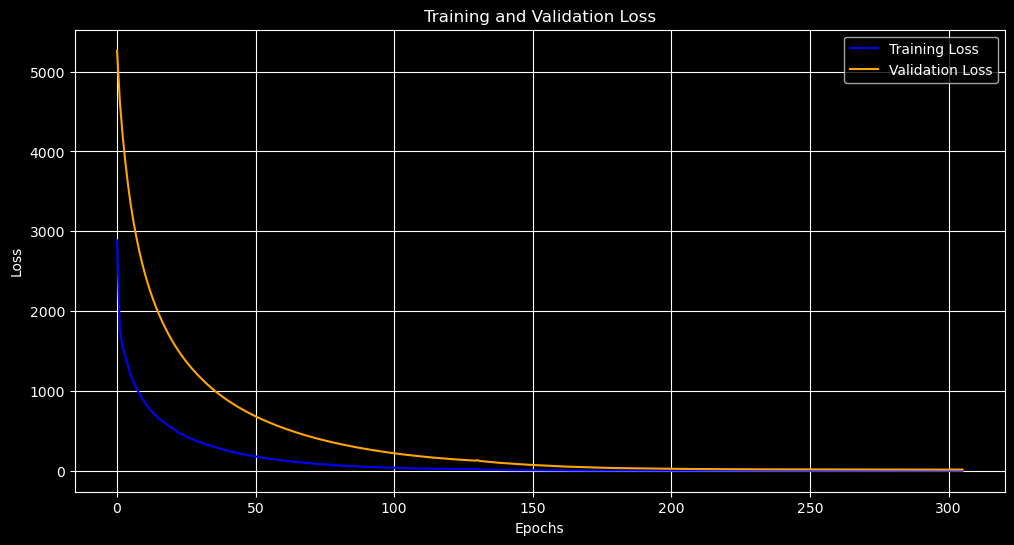

In [115]:
# Plot tran val losses
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
plt.plot(train_loss_arr, label='Training Loss', color='blue')
plt.plot(val_loss_arr, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.legend()
plt.grid(True)
plt.show()

In [116]:
### Test set ###
all_price_preds = []
all_conf_preds = []

with torch.no_grad():
    for X, _ in test_loader:  # _ if targets included, ignore during inference
        X = X.to(device)
        price_preds, conf_preds = model(X)
        all_price_preds.append(price_preds.cpu())
        all_conf_preds.append(conf_preds.cpu())

# Concatenate all batches
all_price_preds = torch.cat(all_price_preds, dim=0).numpy()
all_conf_preds = torch.cat(all_conf_preds, dim=0).numpy()

print("Test Price Predictions shape:", all_price_preds.shape)
print("Test Confidence Predictions shape:", all_conf_preds.shape)

print(all_price_preds[:5])  # Display first 5 predictions
print(all_conf_preds[:5])  # Display first 5 confidence predictions
print('max conf:', np.max(all_conf_preds), 'max price:', np.max(all_price_preds))

Test Price Predictions shape: (332, 4)
Test Confidence Predictions shape: (332, 4)
[[135.15541 135.17998 135.4508  135.32439]
 [135.16467 135.18915 135.46146 135.33194]
 [135.18117 135.20512 135.48087 135.34486]
 [135.19554 135.21904 135.49768 135.35576]
 [135.21368 135.23663 135.51936 135.36949]]
[[45.62922  45.275684 49.43144  40.26083 ]
 [45.612988 45.254368 49.41477  40.242397]
 [45.5823   45.214436 49.38318  40.207417]
 [45.55316  45.176453 49.353035 40.174164]
 [45.511925 45.12292  49.310276 40.12734 ]]
max conf: 50.030285 max price: 135.61958
